In [6]:
import pandas as pd
import glob, os
#import matplotlib.pyplot as plt
#from matplotlib.dates import DateFormatter
import datetime
import seaborn as sns
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import holidays
from fbprophet.diagnostics import cross_validation
import numpy as np
import matplotlib.pyplot as plt

In [8]:
dir_res="D:\\Data\\NYC\\2018"
os.chdir(dir_res)

li=[]

for file in glob.glob("*.csv"):
    df=pd.read_csv(file, index_col=None, header=0)
    li.append(df)

dir_res="D:\\Data\\NYC\\2019"
os.chdir(dir_res)

for file in glob.glob("*.csv"):
    df=pd.read_csv(file, index_col=None, header=0)
    li.append(df)
    
frame = pd.concat(li, axis=0, ignore_index=True)

#fig2=plt.figure(figsize=(30, 20))  # Set figsize to increase size of figure
#ax3 = fig2.add_subplot(1,1,1)
#ax3.plot(frame['Time Stamp'], frame['Load'],'r-')
#plt.show()

frame['Time Stamp'] = pd.to_datetime(frame['Time Stamp'])

df=frame.copy()

df=df.rename(columns={"Time Stamp":"ds", "Load":"y"})
#df=df.set_index('ds')

frame=frame.set_index('Time Stamp')

df

,y,ds
0,6073.3,2018-01-01 00:00:00
1,5905.7,2018-01-01 01:00:00
2,5744.7,2018-01-01 02:00:00
3,5625.7,2018-01-01 03:00:00
4,5572.0,2018-01-01 04:00:00
...,...,...
17515,5909.3,2019-12-31 19:00:00
17516,5689.2,2019-12-31 20:00:00
17517,5488.3,2019-12-31 21:00:00
17518,5276.0,2019-12-31 22:00:00


Let's look at the N.Y.C. load data for 2018 and 2019 that will be used for forecast

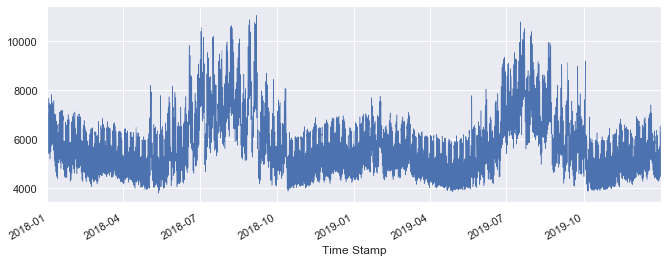

In [9]:
sns.set(rc={'figure.figsize':(11, 4)})
frame['Load'].plot(linewidth=0.5)

In [11]:
l=[]
for ptr in holidays.US(years = [2018, 2019]).items():
   l.append(ptr)
   df_hol = pd.DataFrame(l, columns =['ds', 'holiday'])

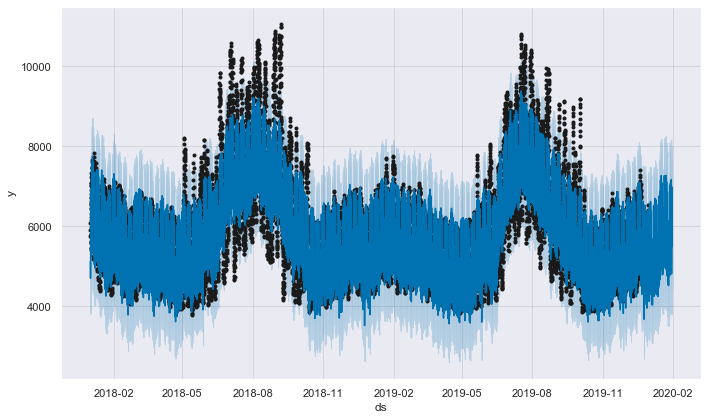

In [16]:
m = Prophet(interval_width=0.95,
            holidays=df_hol,
            holidays_prior_scale=0.05,
            changepoint_prior_scale=0.1,
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=False,
            ).add_seasonality(
                    name='monthly',
                    period=30.5,
                    fourier_order=12
                    ).add_seasonality(
                            name="daily",
                            period=1,
                            fourier_order=15
                            ).add_seasonality(
                                    name="weekly",
                                    period=7,
                                    fourier_order=20
                                    ).add_seasonality(
                                            name="yearly",
                                            period=365.25,
                                            fourier_order=15
                                            ).add_seasonality(
                                                    name="quarterly",
                                                    period=365.25/4,
                                                    fourier_order=5,
                                                    prior_scale=15)
m.fit(df)
future = m.make_future_dataframe(periods=24*30, freq='H')

forecast = m.predict(future)
#forecast1=m.predict_uncertainty(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1=m.plot(forecast)

Let's look at trend and the forecast. Uncertainty interval of 95%, red dashed lines define the point where the trend changes it's behaviour. Thus, trend is piecewise-linear.

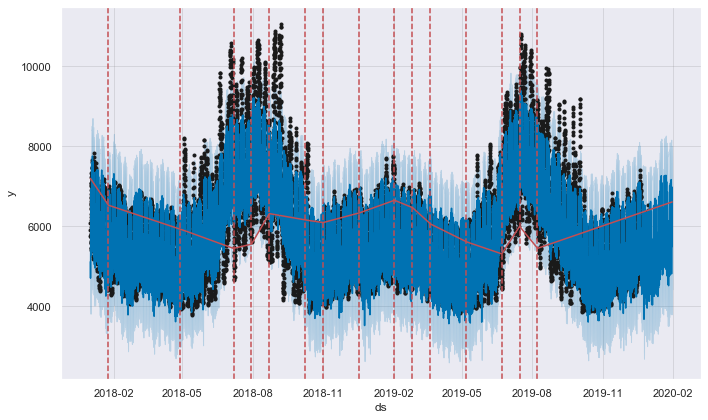

In [17]:
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig1

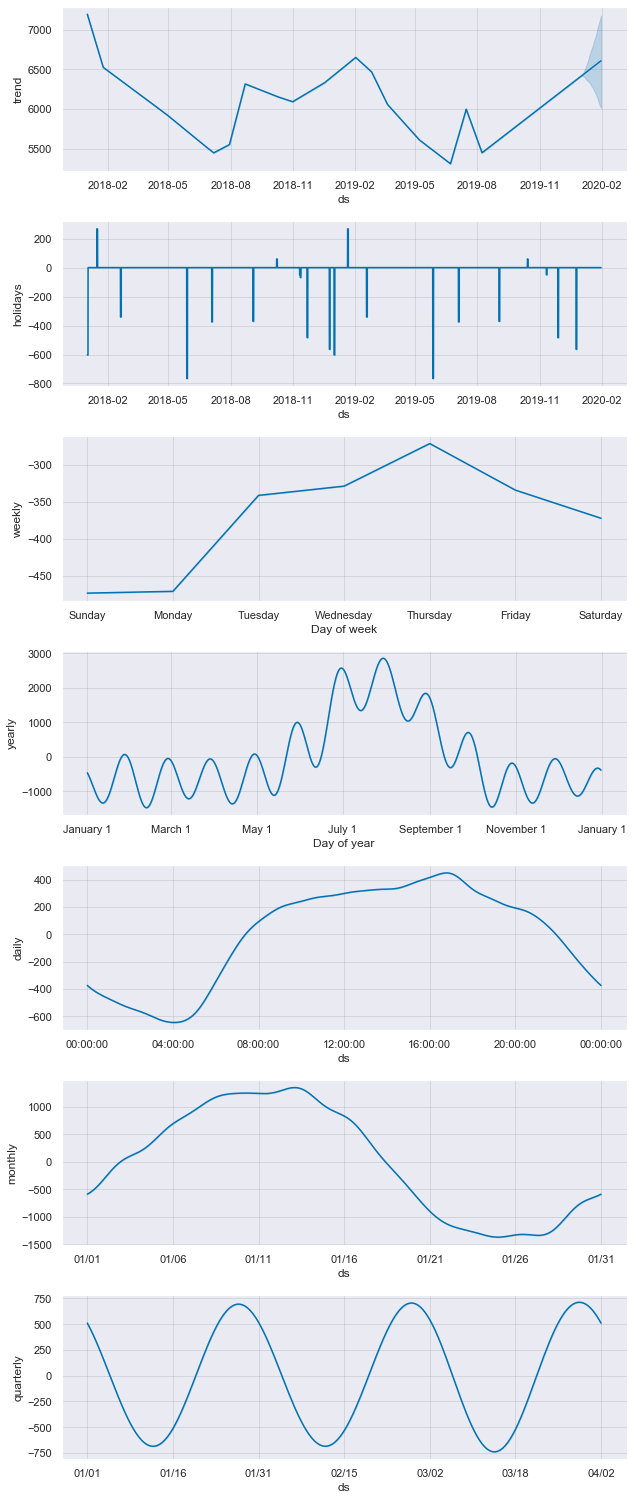

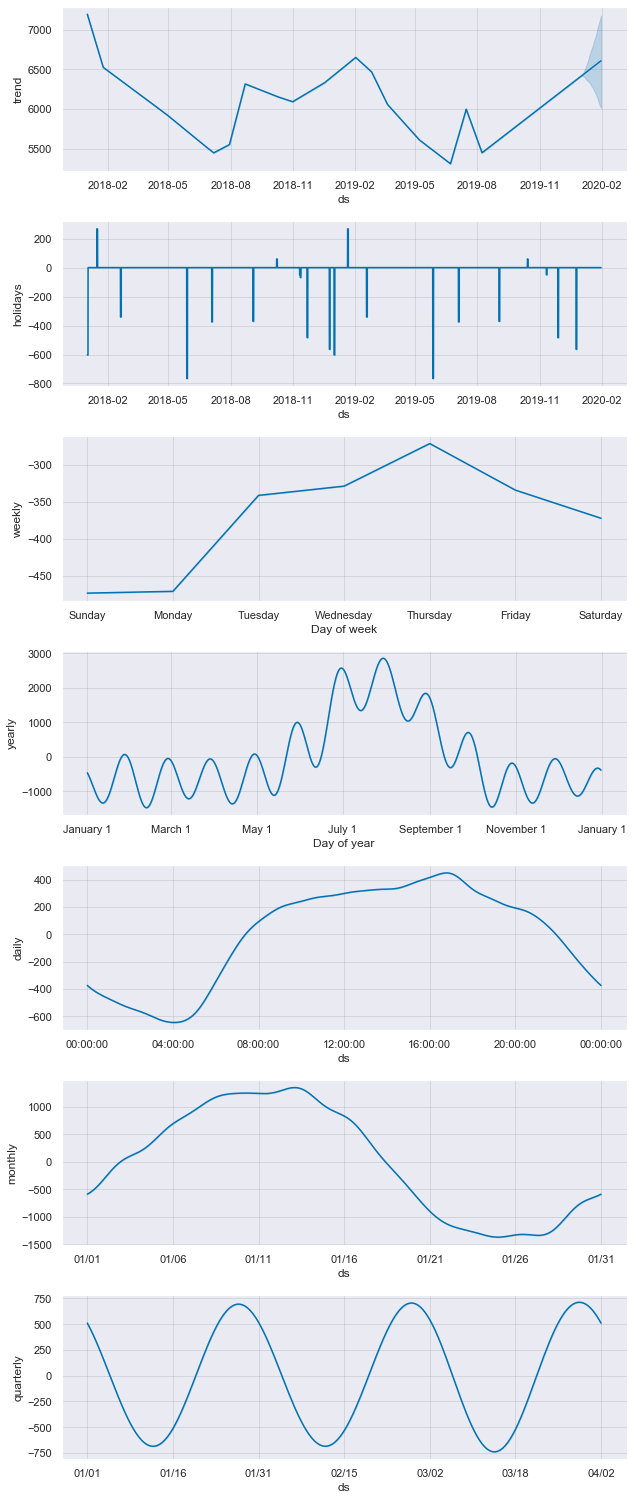

In [18]:
m.plot_components(forecast)

MAPE error in percent that is received via cross validation:

In [19]:
def MAPE(y_true, y_pred):
    y_true, y_pred=np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

cv_results=cross_validation(m, initial='12000 hours', period='3600 hours', horizon = '168 hours')

mape_baseline=MAPE(cv_results.y, cv_results.yhat)

print(mape_baseline)

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-07-27 23:00:00 and 2019-12-24 23:00:00


6.409489933730701


Loading real load of N.Y.C. during 2020 year

In [21]:
dir_res="D:\\Data\\NYC\\2020"
os.chdir(dir_res)
li=[]

for file in glob.glob("*.csv"):
    df2020=pd.read_csv(file, index_col=None, header=0)
    li.append(df2020)
    
frame_true = pd.concat(li, axis=0, ignore_index=True)

MAPE error in percent received by comparing the forecast for first month of 2020 load and true load:

In [22]:
frame_true['Time Stamp'] = pd.to_datetime(frame_true['Time Stamp'])

frame_true=frame_true.set_index('Time Stamp')
df_hat=forecast.copy()
df_hat=df_hat.set_index('ds')

mergedDf = frame_true.merge(df_hat, left_index=True, right_index=True)

print(MAPE(mergedDf['Load'], mergedDf['yhat']))

5.839547624730763


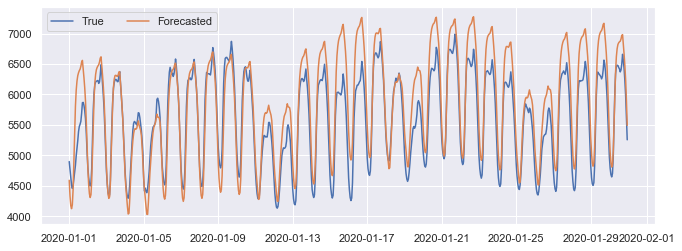

In [23]:
sns.set(rc={'figure.figsize':(11, 4)})
plt.plot(mergedDf.index, mergedDf['Load'], label="True")
plt.plot(mergedDf.index, mergedDf['yhat'], label="Forecasted")
plt.legend(ncol=2, loc='upper left')